# Milestone 2

Import all needed libraries and read the data set that has been cleaned as a result of milestone 1. 

In [38]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, r2_score

In [29]:
df_bike_clean = pd.read_csv("bike_data_clean.csv")
df_bike_clean.head()

,START TIME,BIKE ID,TRIP DURATION,FROM STATION ID,USER TYPE,GENDER,FROM LATITUDE,FROM LONGITUDE,AGE
0,04/03/2019 08:29:54 AM,5313,537,18,Subscriber,Male,41.883132,-87.637321,37
1,04/03/2019 08:29:52 AM,5884,224,137,Subscriber,Male,41.862378,-87.651062,54
2,04/03/2019 08:29:52 AM,4048,1085,210,Subscriber,Male,41.903450,-87.667747,32
3,04/03/2019 08:29:50 AM,2638,309,96,Subscriber,Male,41.884616,-87.644571,31
4,04/03/2019 08:29:45 AM,3179,501,77,Subscriber,Male,41.882242,-87.641066,41


# Add new feature: `weekdays`

Sort the starting time by weekdays. In one hot encoding, one category is left out in order to avoid  multicollinearity. (in this case: `Sunday`)


First, the `START TIME` needs to be converted to datetime value in order to be usable for the following task. We keep the original cleaned data set by making a copy of it to continue with the steps.

In [30]:
# sort into weekdays
# one hot coded columns method

# first convert START TIME to datetime value
df_bike_clean['START TIME'] = pd.to_datetime(df_bike_clean['START TIME'])
df_bike_cleaned = df_bike_clean.copy()

# extract day the of the week
df_bike_cleaned['DAY OF WEEK'] = df_bike_cleaned["START TIME"].dt.day_name()

#ChatGPT: i want to improve the hot one coding because it does not start with monday, the column starts with wednesday
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_bike_cleaned['DAY OF WEEK'] = pd.Categorical(df_bike_cleaned['DAY OF WEEK'], categories=day_order, ordered=True)
# until here ------------------

days_of_week = pd.get_dummies(df_bike_cleaned['DAY OF WEEK'])
days_of_week.drop(columns=["Sunday"], inplace=True)

# add column to database
df_bike_cleaned = pd.concat([df_bike_cleaned, days_of_week], axis=1)

# we do not need the column anymore
df_bike_cleaned.drop(columns=['DAY OF WEEK'], inplace=True)

df_bike_cleaned.head()

,START TIME,BIKE ID,TRIP DURATION,FROM STATION ID,USER TYPE,GENDER,FROM LATITUDE,FROM LONGITUDE,AGE,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
0,2019-04-03 08:29:54,5313,537,18,Subscriber,Male,41.883132,-87.637321,37,False,False,True,False,False,False
1,2019-04-03 08:29:52,5884,224,137,Subscriber,Male,41.862378,-87.651062,54,False,False,True,False,False,False
2,2019-04-03 08:29:52,4048,1085,210,Subscriber,Male,41.903450,-87.667747,32,False,False,True,False,False,False
3,2019-04-03 08:29:50,2638,309,96,Subscriber,Male,41.884616,-87.644571,31,False,False,True,False,False,False
4,2019-04-03 08:29:45,3179,501,77,Subscriber,Male,41.882242,-87.641066,41,False,False,True,False,False,False


# Add new feature: `hour`

In [31]:
#hour of day 
df_bike_cleaned['START TIME'] = pd.to_datetime(df_bike_cleaned['START TIME'])
df_bike_cleaned['HOUR OF DAY'] = df_bike_cleaned['START TIME'].dt.hour
df_bike_cleaned.tail()

,START TIME,BIKE ID,TRIP DURATION,FROM STATION ID,USER TYPE,GENDER,FROM LATITUDE,FROM LONGITUDE,AGE,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,HOUR OF DAY
156218,2019-03-05 17:18:57,4667,234,145,Subscriber,Male,41.898587,-87.621915,68,False,True,False,False,False,False,17
156219,2019-03-05 17:18:52,1667,387,638,Subscriber,Male,41.878419,-87.640977,36,False,True,False,False,False,False,17
156220,2019-03-05 17:18:51,1694,591,110,Subscriber,Male,41.893992,-87.629318,48,False,True,False,False,False,False,17
156221,2019-03-05 17:18:42,1464,335,44,Subscriber,Male,41.884730,-87.627734,40,False,True,False,False,False,False,17
156222,2019-03-05 17:18:39,2699,492,44,Subscriber,Male,41.884730,-87.627734,60,False,True,False,False,False,False,17


# Visualization:
Number of bike trips starting and concurrent bike usage for every `hour` of day

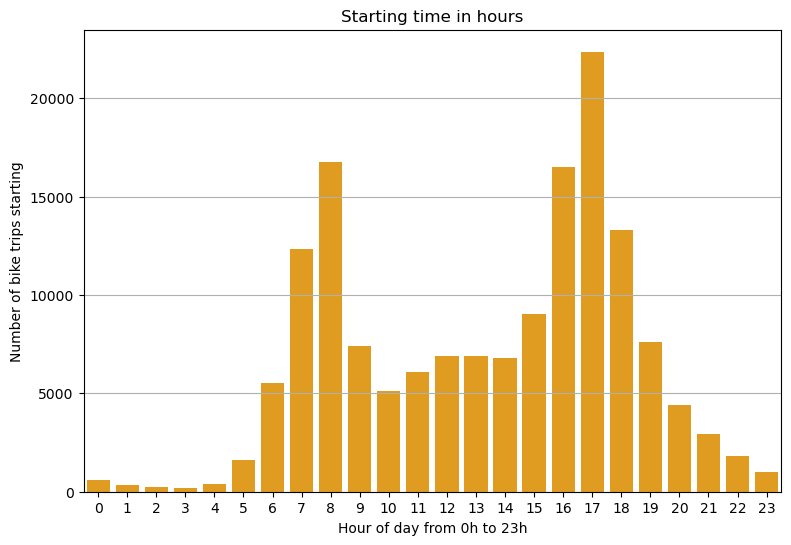

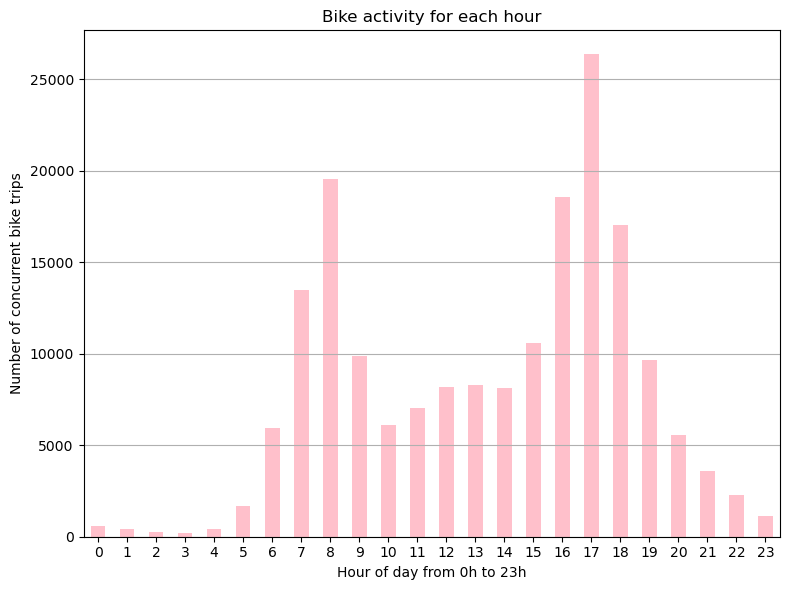

In [32]:
# Visualization 1
# bar chart how many trips startet in each hour
plt.figure(figsize=(9,6))
sns.countplot(x='HOUR OF DAY', data=df_bike_cleaned, color= "orange")

plt.title("Starting time in hours")
plt.xlabel("Hour of day from 0h to 23h")
plt.ylabel("Number of bike trips starting")
plt.grid(axis= 'y')
plt.show()


# Visualization 2
# determine end time: end time = start time plus the trip duration
df_bike_cleaned['END TIME'] = df_bike_cleaned['START TIME'] + pd.to_timedelta(df_bike_cleaned['TRIP DURATION'], unit='s')

# we need an array or series to count bike trips each hour
count_hours = pd.Series(0, index=range(24))


# in ChatGPT: in python how do i make a loop with every row of the dataset
# Answer: Good question! To loop through every row of a dataset (e.g., a pandas DataFrame), there are several common ways in Python.
#         (...) for _, row in df.iterrows(): (...) _ is used to ignore the row index (...)
for _, row in df_bike_cleaned.iterrows(): 

    start_hour = row['HOUR OF DAY']
    end_time = row['END TIME']

    end_hour = end_time.hour

    for hour in range(start_hour, end_hour + 1):
        # for every hour from start to end: add one count 
        count_hours[hour % 24] += 1  

plt.figure(figsize=(8, 6))
count_hours.sort_index().plot(kind='bar', color='pink')

plt.title('Bike activity for each hour')
plt.xlabel('Hour of day from 0h to 23h')
plt.ylabel('Number of concurrent bike trips')
plt.xticks(rotation=0) 
plt.grid(axis='y')
plt.tight_layout()
plt.show()


The overall graphs are very similar with the only difference in the numbers on the y axis. This is to be expected since some bike trips are counted multiple times since it is one count for every hour it reaches. 
Another conclusion that can be drawn from the comparison of these two graphs is that many trips do not exceed one hour durations since the structure would not be similar in that case. 

In [ ]:
bike_trip_mean = df_bike_cleaned['TRIP DURATION'].aggregate('mean')
print("AVG trip duration: ", bike_trip_mean)

bike_trip_median = df_bike_cleaned['TRIP DURATION'].aggregate('median')
print("Median trip duration: ", bike_trip_median)

print("Max trip duration: ", df_bike_cleaned['TRIP DURATION'].max())

AVG trip duration:  824.4359089250622
Median trip duration:  524.0
Max trip duration:  6096430


Since there are very few bike trips that exceed an duration of two hours in comparison to the amount under two hours,
we will exclude any entry over 2 hours.
Outliers like a max trip duration of 6,096,430 seconds (about 1693hours) seem unrealistic and will distort the graphs.


In [34]:
df_bike_cleaned = df_bike_cleaned[df_bike_cleaned["TRIP DURATION"] <= 7200]


# Gender distribution


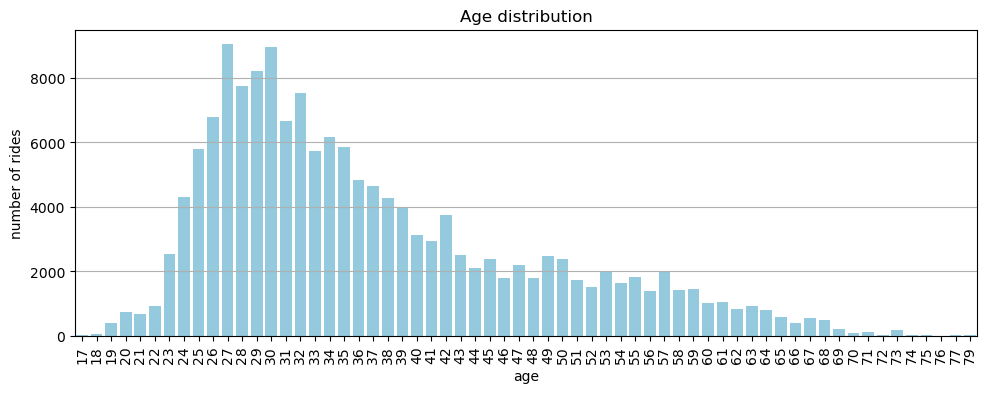

In [35]:
plt.figure(figsize=(10,4))
sns.countplot(x='AGE', data=df_bike_cleaned, color= "skyblue")

plt.title("Age distribution")
plt.xlabel("age")
plt.ylabel("number of rides")
plt.grid(axis= 'y')
plt.tight_layout()
plt.xticks(rotation = 90)
plt.show()

# Linear Regression and K-Nearest Neighbours

In [54]:
xa = df_bike_cleaned[["AGE"]]
ya = df_bike_cleaned["TRIP DURATION"]

X_train, X_test, y_train, y_test = train_test_split(xa, ya, test_size=0.3, random_state = 30)
polyRange = PolynomialFeatures(degree = 3, include_bias = False)
X_train_poly = polyRange.fit_transform(X_train.values.reshape(-1, 1))
X_test_poly = polyRange.fit_transform(X_test.values.reshape(-1, 1))

scaler = StandardScaler()   
X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_test_poly_scaled = scaler.transform(X_test_poly) # no fit transform, already fitted before

lin_model = LinearRegression()
lin_model.fit(X_train_poly_scaled, y_train)

knn_model = KNeighborsRegressor(n_neighbors = 100)
knn_model.fit(X_train_poly_scaled, y_train)

y_pred_lin = lin_model.predict(X_test_poly_scaled)
y_pred_knn = knn_model.predict(X_test_poly_scaled)  

mae_lin = mean_absolute_error(y_test, y_pred_lin)
mae_knn = mean_absolute_error(y_test, y_pred_knn)

r2_lin = r2_score(y_test, y_pred_lin)
r2_knn = r2_score(y_test, y_pred_knn)

print("LinearRegression:")
print("MAE: ", mae_lin)
print("R2: ", r2_lin)

print("KNN: ")
print("MAE: ", mae_knn)
print("R2: ", r2_knn)

LinearRegression:
MAE:  386.674328779671
R2:  0.0019169991957577182
KNN: 
MAE:  390.58699224010775
R2:  -0.0030499856484400567


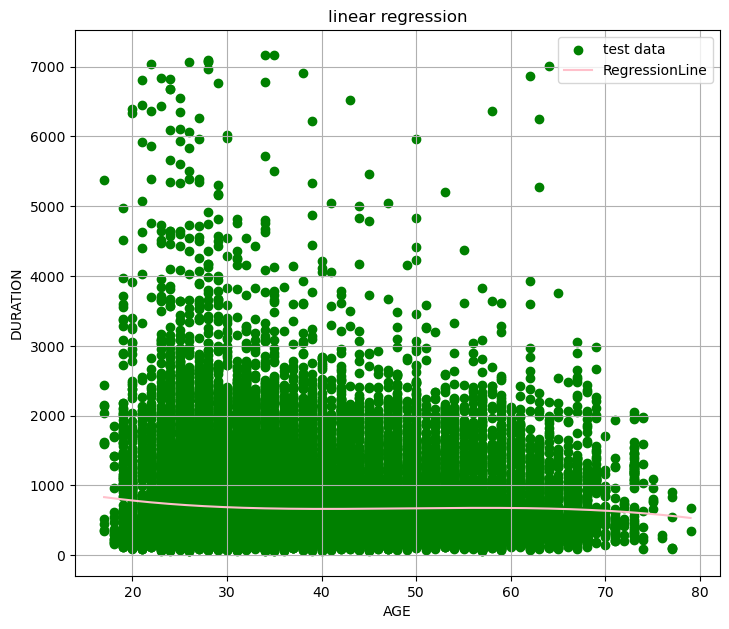

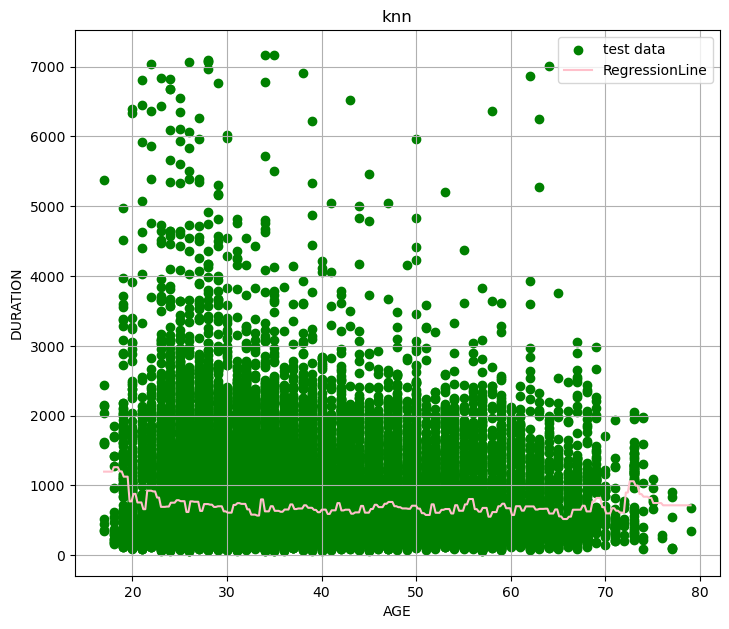

In [55]:
temp_range = np.linspace(X_test.min(), X_test.max(), 300).reshape(-1, 1)
temp_range_poly = polyRange.transform(temp_range)
temp_range_poly_scaled = scaler.transform(temp_range_poly)

y_pred_test = lin_model.predict(X_test_poly_scaled)
y_pred_line = lin_model.predict(temp_range_poly_scaled)

plt.figure(figsize= (14, 12))
plt.subplot(2, 2, 1)
plt.scatter(X_test, y_test, color="green", label= "test data")
plt.plot(temp_range, y_pred_line, color="pink", label = "RegressionLine" )
plt.xlabel("AGE")
plt.ylabel("DURATION")
plt.title("linear regression")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


y_pred_test = knn_model.predict(X_test_poly_scaled)
y_pred_line = knn_model.predict(temp_range_poly_scaled)

plt.figure(figsize= (14, 12))
plt.subplot(2, 2, 2)
plt.scatter(X_test, y_test, color="green", label= "test data")
plt.plot(temp_range, y_pred_line, color="pink", label = "RegressionLine" )
plt.xlabel("AGE")
plt.ylabel("DURATION")
plt.title("knn")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()